# Noise and Batch Size in Linear Regression

This notebook compares noise level vs batch size in solving a linear regression problem.

I find that processing time is proportional to the number of batchs completed.

With enough data, a batch size of 32 is always best.
Although it appears that the smaller batch sizes are all converging to the same result.
There doesn't seem to be any drawback to using a batch size of 32.

## Preliminaries

In [1]:
import tensorflow as tf
from numpy import random, set_printoptions, array, meshgrid, linspace, asarray, transpose, zeros, sort, sum as npsum
import matplotlib.pyplot as plt

In [2]:
print('tf version: {}'.format(tf.VERSION))
set_printoptions(3)

tf version: 1.7.0


## Model

In [3]:
X = tf.placeholder("float")
Y = tf.placeholder("float")

W = tf.Variable([1.0], name="weight")
b = tf.Variable([1.0], name="bias")

pred = tf.add(tf.multiply(X, W), b)
mse = tf.losses.mean_squared_error(Y, pred)

gd = tf.train.GradientDescentOptimizer(0.01).minimize(mse)
adam = tf.train.AdamOptimizer(0.01).minimize(mse)

init = tf.global_variables_initializer()

Set the ground truth for the model parameters

In [4]:
Wstar = array([0.5])
bstar = array([0.25])

`generate` returns `n` data points adjusted by normally distributed points with standard deviation of `noise`.

In [5]:
def generate(n, W=Wstar, b=bstar, noise=None):
    x = sort(random.rand(n))
    y = x * W + b
    if noise != None:
        y += random.normal(0.0, noise, y.shape)
    return x, y

`train` runs an optimization.
It returns a path of results.
The first element is always the initial position.
The last element is always the final position.
If `reports` is greater than 0, then at least that many intermediate results are also returned.

In [6]:
def train(epochs=1000, batchs=1, samples=32, testsamples=32, noise=None, reports=0, step=gd):

    if len(samples) == 1:
        x, y = generate(batchs * samples, noise=noise)
    else:
        x, y = samples
        if len(x) % batchs != 0:
            raise ValueError('data length is not a multiple of batchs')
        samples = len(x) // batchs

    if len(testsamples) == 1:
        u, v = generate(testsamples, noise=noise)
    else:
        u, v = testsamples
        testsamples = len(u)
    test_fd = {X: u, Y: v}

    def testresults(epoch):
        res = sess.run([mse, W, b], feed_dict=test_fd)
        return epoch, res[0], res[1][0], res[2][0]
    
    if reports == 0:
        epath = epochs + 2
    elif reports > epochs:
        epath = 1
    else:
        epath = epochs // reports
    
    with tf.Session() as sess:
        sess.run(init)
        path = [testresults(0)]
        
        for epoch in range(1, epochs+1):
            lr = 0
            for batch in range(batchs):
                nr = lr + samples
                sess.run(step, feed_dict={X: x[lr:nr], Y: y[lr:nr]})
                lr = nr
            if epoch % epath == 0:
                path.append(testresults(epoch))

        path.append(testresults(epochs+1))
        
        return path

In [7]:
gs32 = generate(32, noise=0.1)
gt32 = generate(32, noise=0.1)

gs1024 = generate(1024, noise=0.1)
gt1024 = generate(1024, noise=0.1)

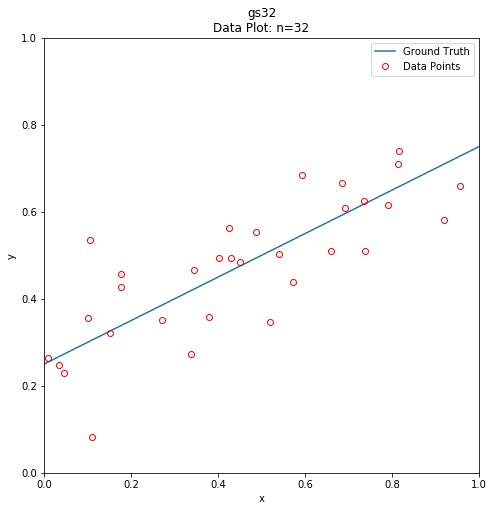

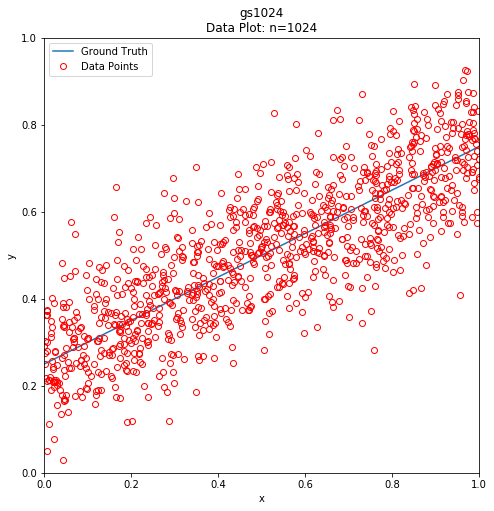

In [8]:
def dataplot(gs, title):
    x = [0, 1]
    y = x * Wstar + bstar
    plt.figure(figsize=(8, 8))

    plt.plot(x, y, label='Ground Truth')
    
    x, y = gs
    plt.plot(x, y, 'ro', label='Data Points', mfc='none')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('{}\nData Plot: n={}'.format(title, len(gs[0])))
    plt.xlim(0., 1.)
    plt.ylim(0., 1.)
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.show()
    return

dataplot(gs32, 'gs32')
dataplot(gs1024, 'gs1024')

## Time comparison

Using only 32 total samples, I compare all possible batch sizes. Fewer batches (involving fewer evaluations and better gradient estimates) run faster.

In [9]:
for bits in range(6):
    batchs = 2**bits
    print('       batch {}'.format(batchs))
    %timeit train(epochs=100, batchs=batchs, samples=gs1024, testsamples=gt1024)

       batch 1
241 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
       batch 2
330 ms ± 34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
       batch 4
445 ms ± 23.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
       batch 8
690 ms ± 4.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
       batch 16
1.2 s ± 8.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
       batch 32
2.23 s ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Here is a plot using the results from my laptop. The runtime is proportional to the number of evaluations (at least for these small data sets).

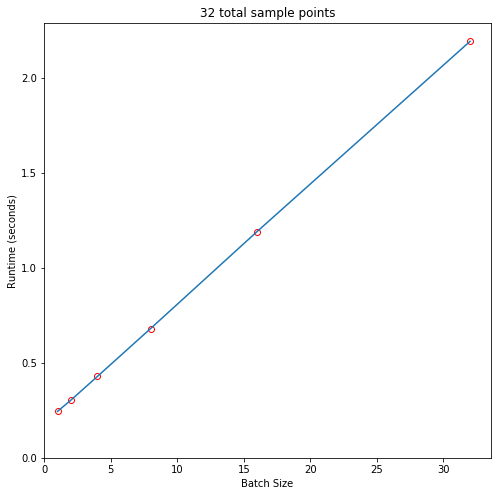

In [10]:
plt.figure(figsize=(8, 8))
plt.plot([1, 2, 4, 8, 16, 32], [0.244, 0.303, 0.428, 0.680, 1.19, 2.19], 'ro', mfc='none')
plt.plot([1, 2, 4, 8, 16, 32], [0.244, 0.303, 0.428, 0.680, 1.19, 2.19])
plt.xlabel('Batch Size')
plt.ylabel('Runtime (seconds)')
plt.title('32 total sample points')
plt.xlim(0.)
plt.ylim(0.)
plt.show()

## Line plots

This section displays fitted line plots at several noise levels.

In [11]:
def lineplot(path, title):
    x = array([0., 1.])
    plt.figure(figsize=(8, 8))

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.plot(x, x * Wstar + bstar, 'k', label='Ground Truth {:.3f} {:.3f}'.format(Wstar[0], bstar[0]))
    
    delta = .9 / len(path)
    alpha = .1 + delta / 2
    
    for epoch, mse, W, b in path:
        plt.plot(x, x * W + b, 'r', alpha=alpha, label='Step {:04d} {:.3f} {:.3f}'.format(epoch, W, b))
        alpha += delta

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(title)
    plt.gca().set_aspect('equal')
    plt.show()
    return

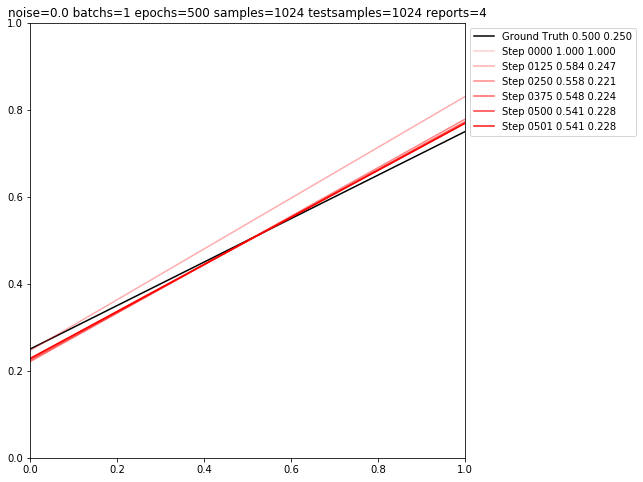

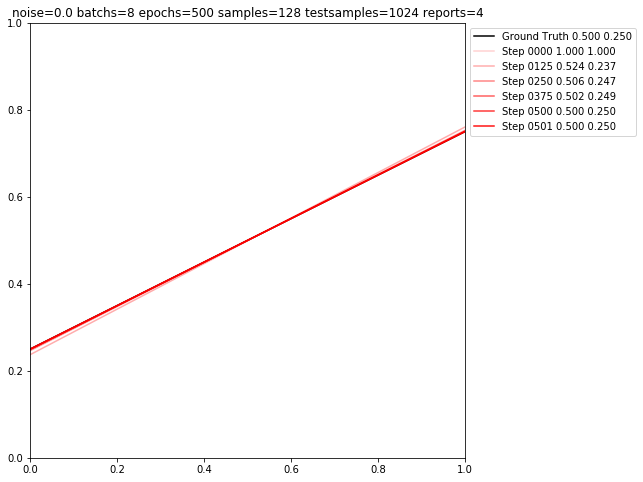

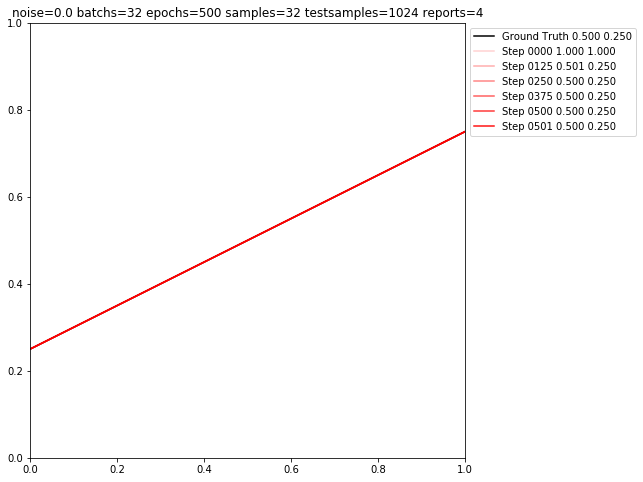

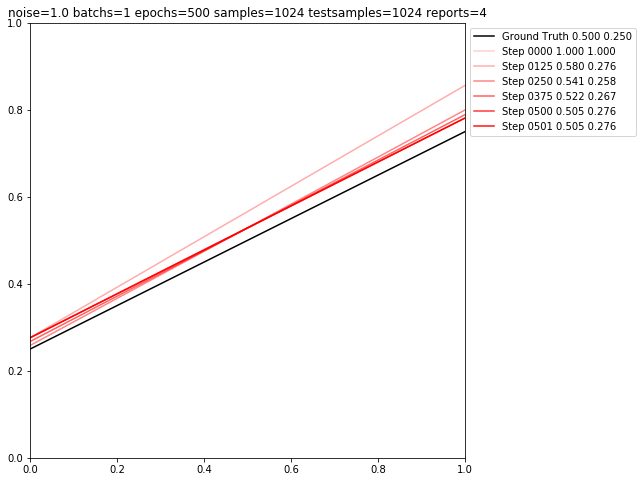

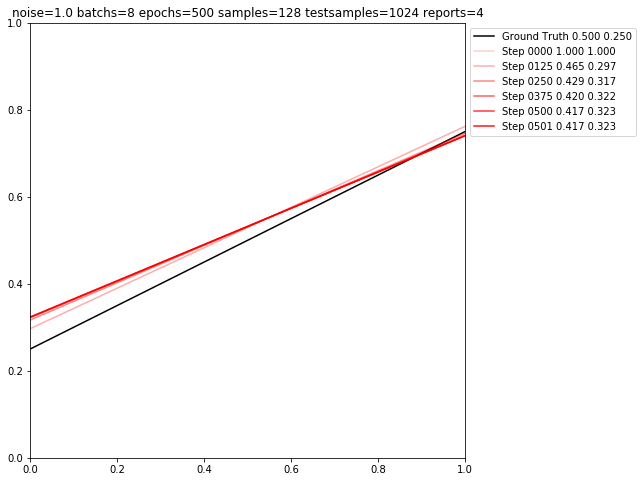

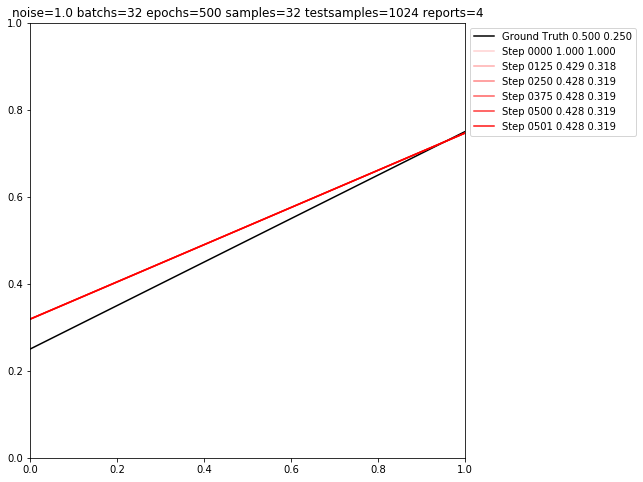

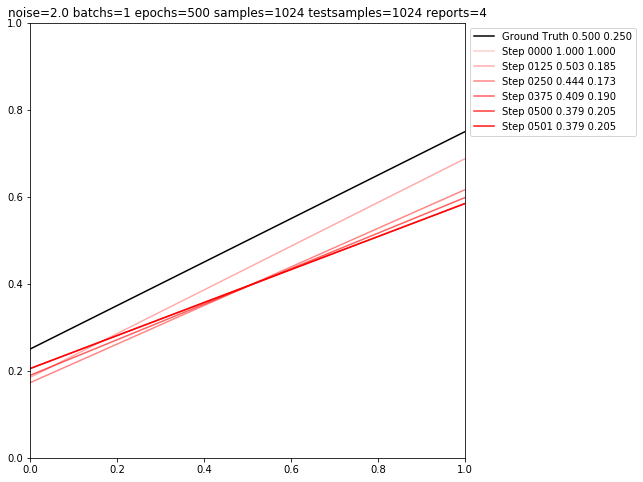

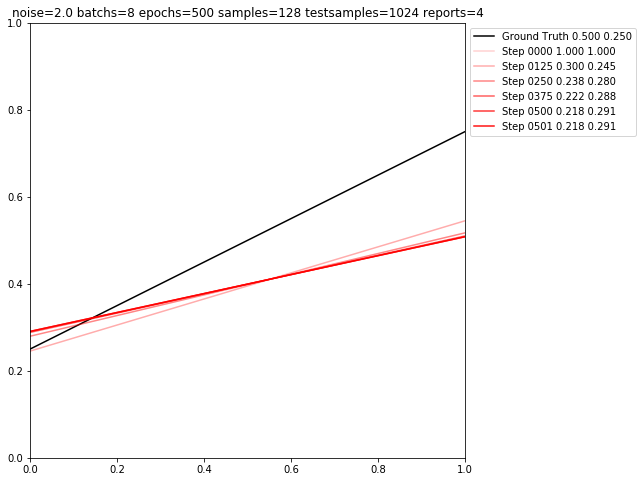

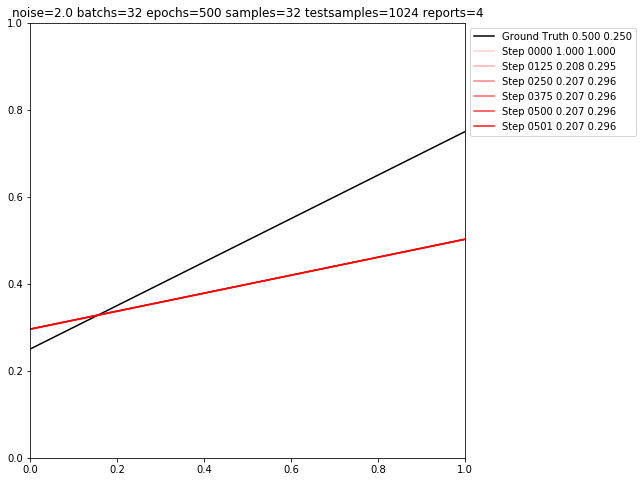

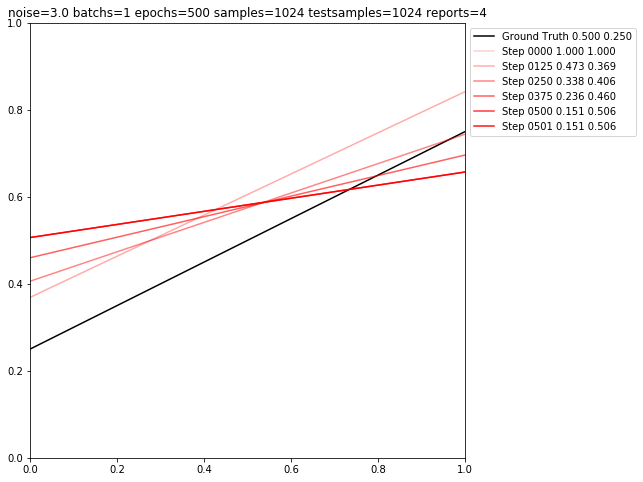

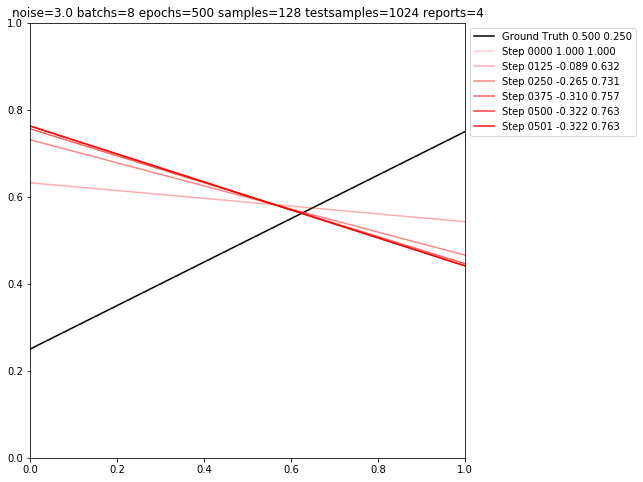

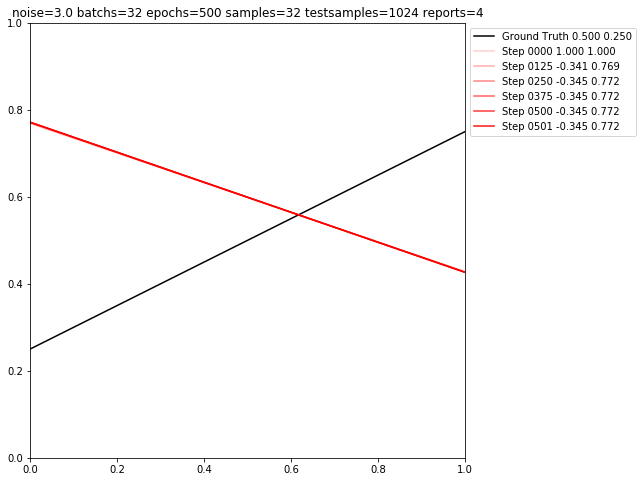

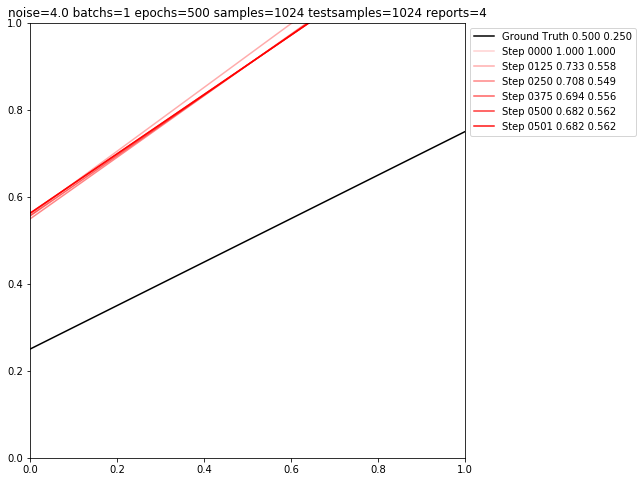

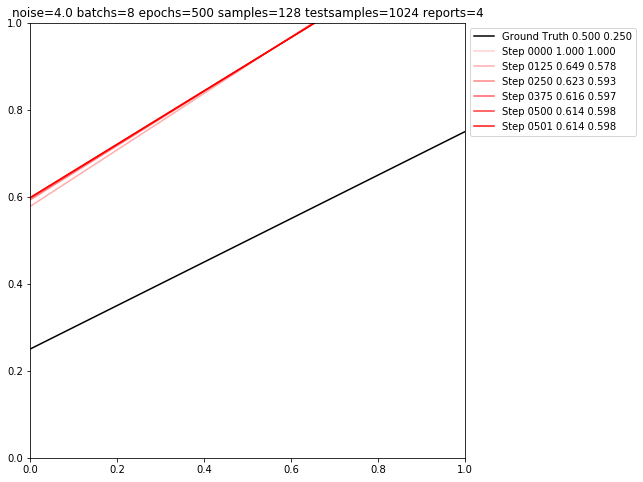

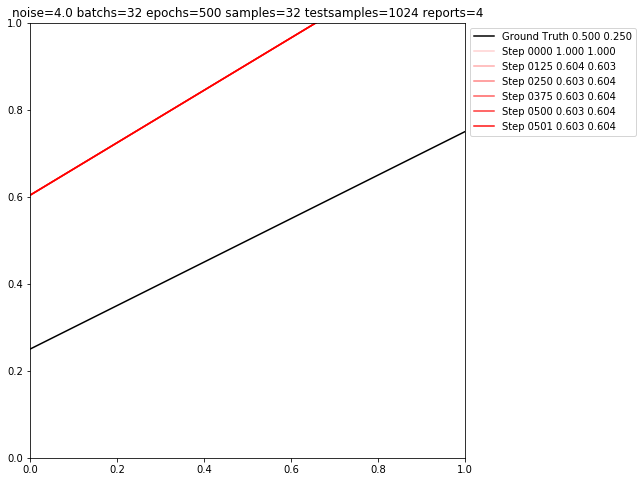

In [12]:
for noise in [0.0, 1.0, 2.0, 3.0, 4.0]:
    g_s1024 = generate(1024, noise=noise)
    g_t1024 = generate(1024, noise=noise)
    for bits in [0, 3, 5]:
        batchs = 2**bits
        lineplot(train(epochs=500, batchs=batchs, samples=g_s1024, testsamples=g_t1024, reports=4),
                'noise={} batchs={} epochs={} samples={} testsamples={} reports={}'.format(
                    noise, batchs, 500, len(g_s1024[0])//batchs, len(g_t1024[0]), 4))

## Parameter plots

The section displays the corresponding parameter space (W, b) at several noise levels.
The path of the optimization is shaded from light to dark.
Even modest noise levels produce significant errors in the intercept parameter, b.

In [13]:
def pathplot(path, title):
    x = array([0., 1.])
    plt.figure(figsize=(8, 8))
    
    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.plot(Wstar, bstar, 'ko', mfc='none', label='Ground Truth {:.3f} {:.3f}'.format(Wstar[0], bstar[0]))
    
    delta = .9 / (len(path)-1)
    alpha = .1 + delta / 2
    
    ftime = True
    for epoch, mse, W, b in path:
        if ftime == False:
            plt.plot([lW, W], [lb, b], 'r', alpha=alpha,
                     label='Step {:04d}-{:04d} {:.3f} {:.3f}'.format(lepoch, epoch, W, b))
            alpha += delta
        else:
            ftime = False
        lepoch, lW, lb = epoch, W, b

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(title)
    plt.xlabel('W')
    plt.ylabel('b')
    plt.gca().set_aspect('equal')
    plt.show()
    return

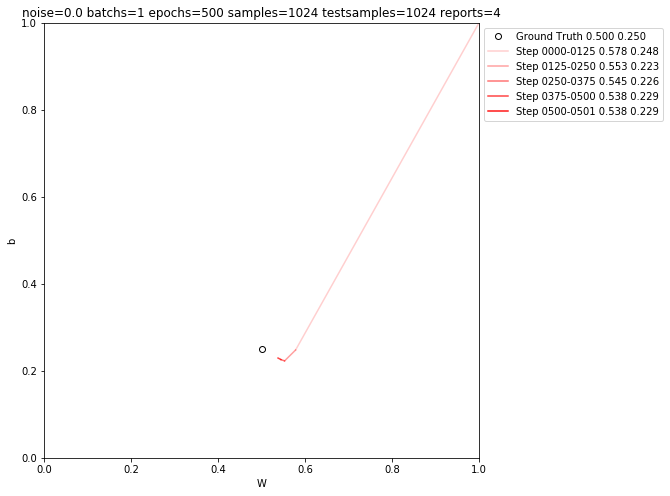

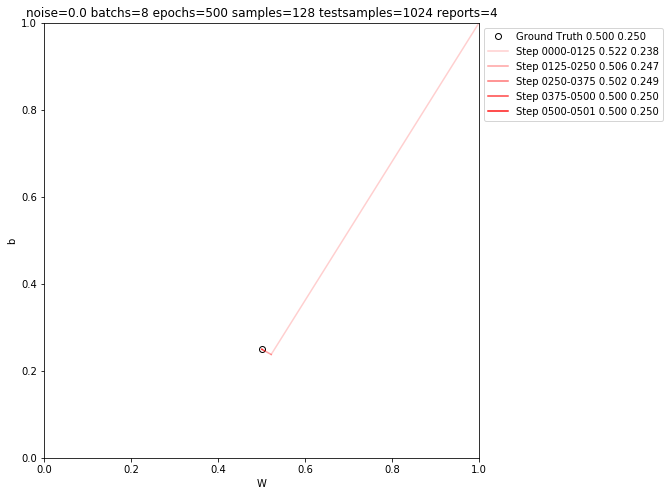

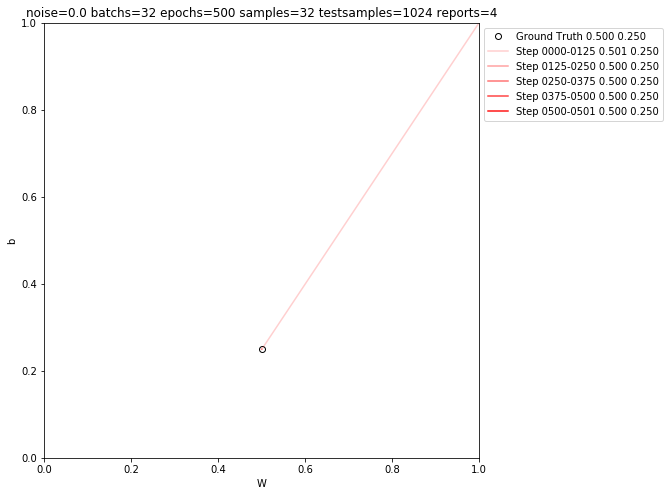

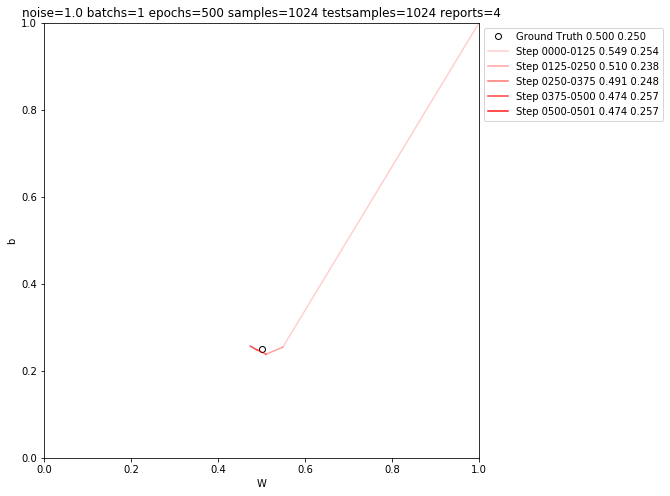

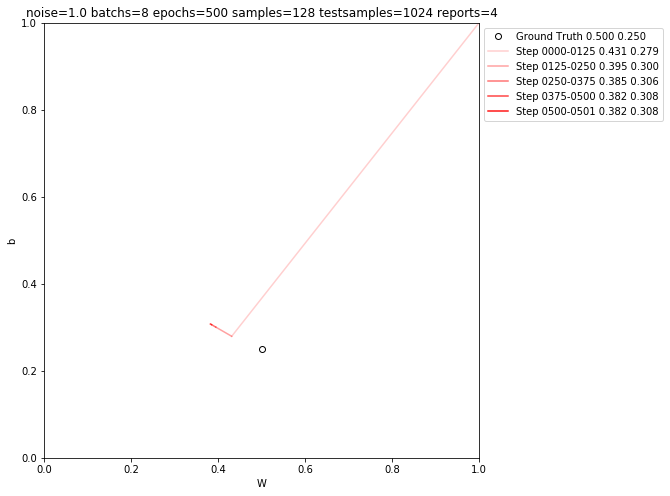

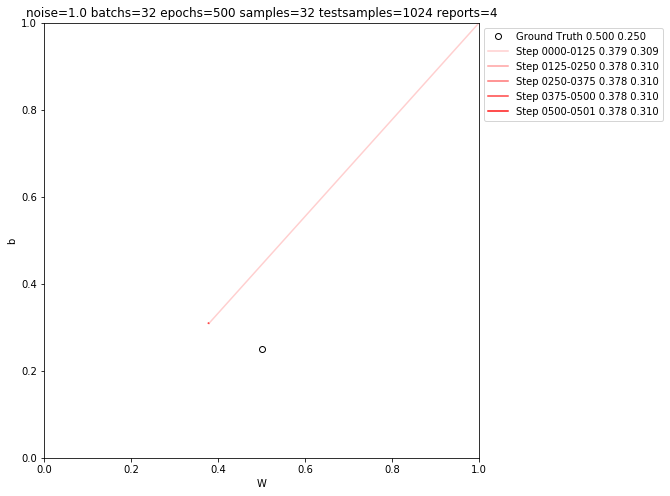

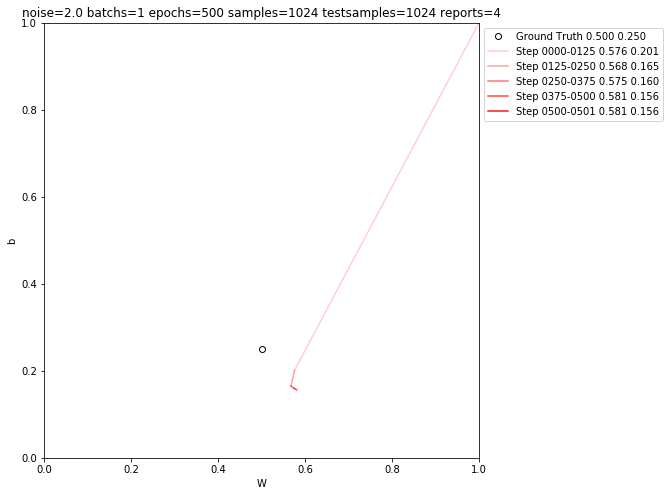

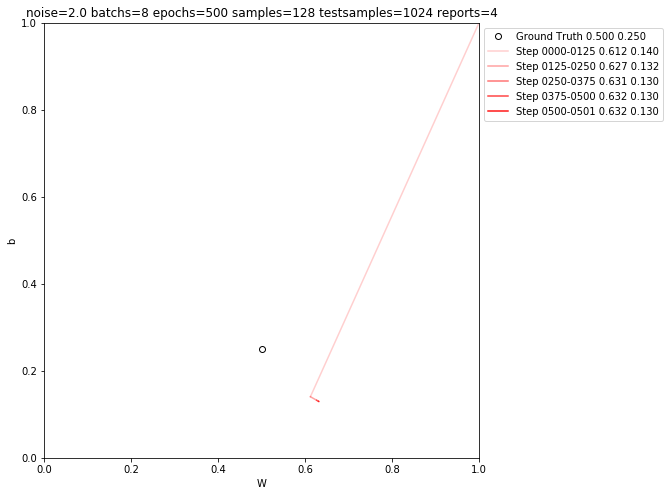

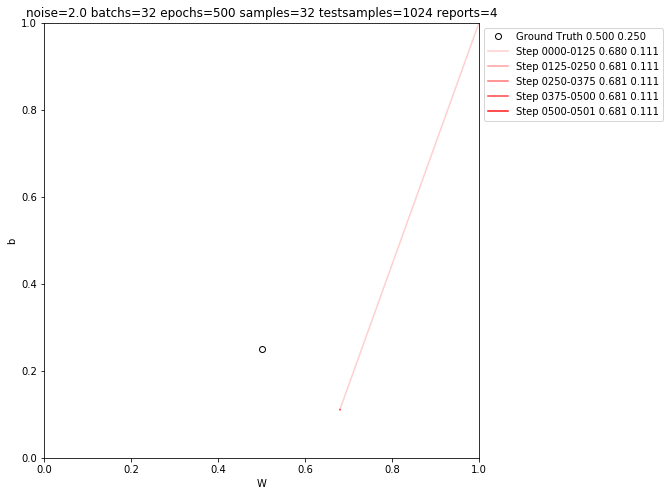

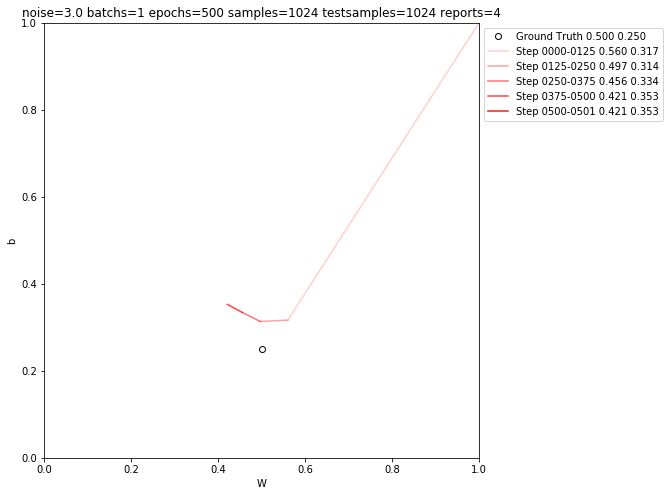

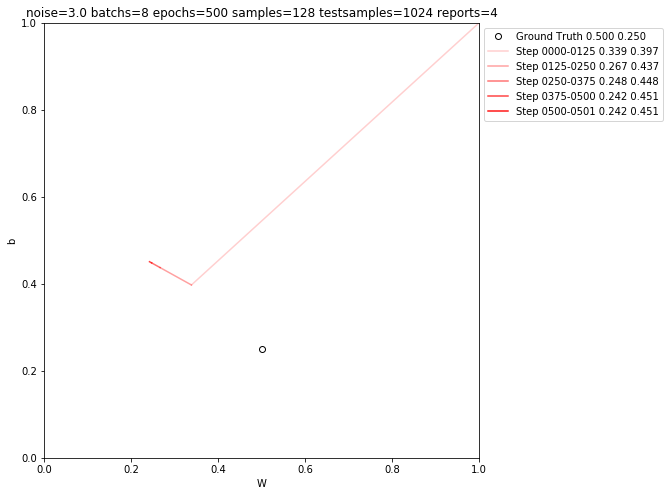

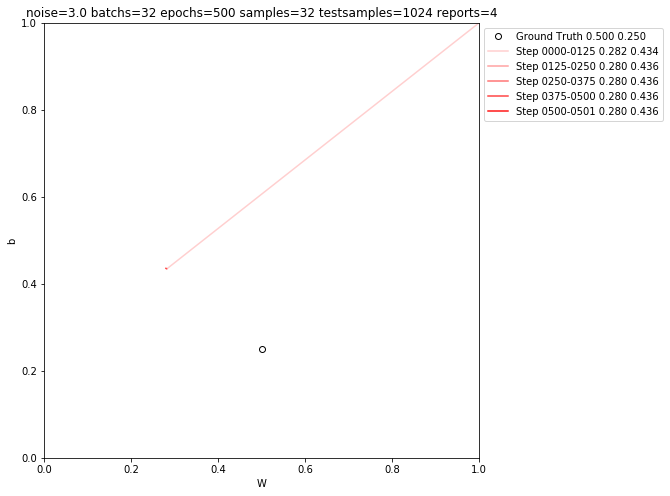

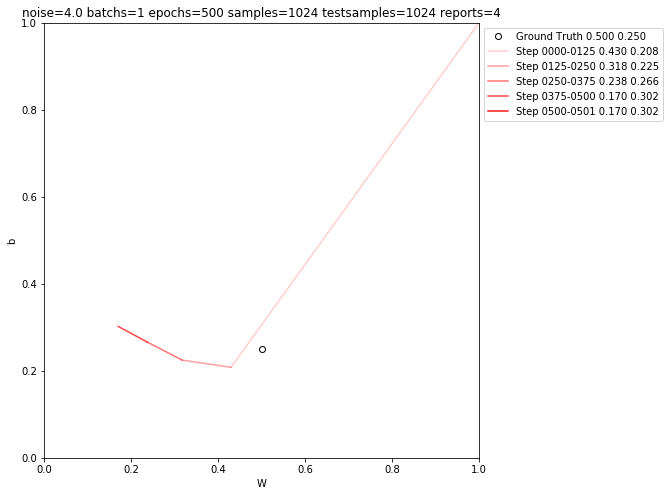

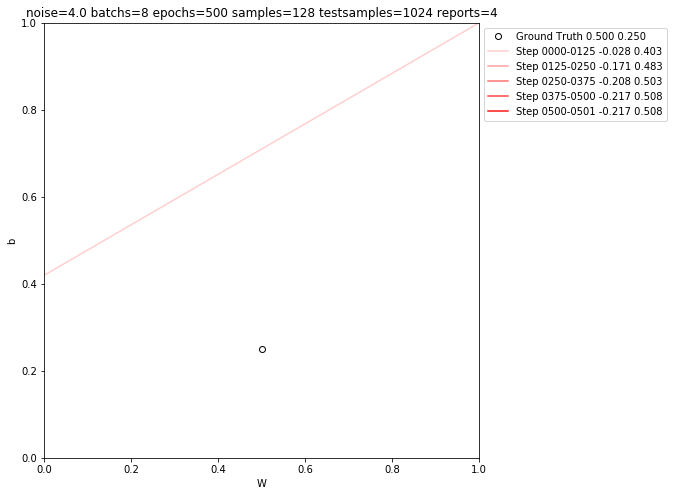

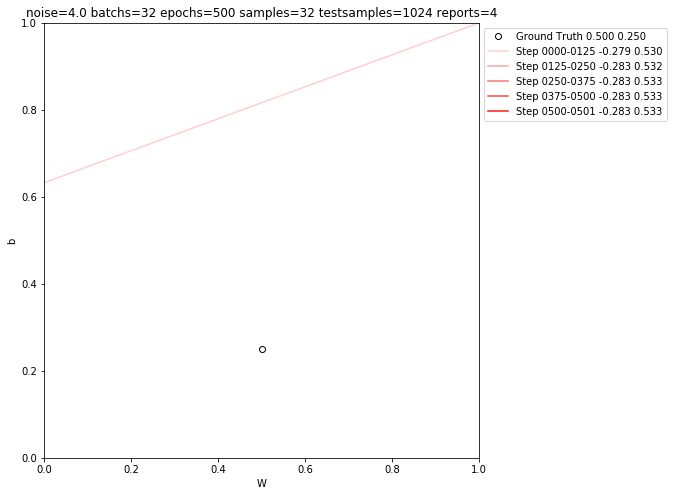

In [14]:
for noise in [0.0, 1.0, 2.0, 3.0, 4.0]:
    g_s1024 = generate(1024, noise=noise)
    g_t1024 = generate(1024, noise=noise)
    for bits in [0, 3, 5]:
        batchs = 2**bits
        pathplot(train(epochs=500, batchs=batchs, samples=g_s1024, testsamples=g_t1024, reports=4),
                'noise={} batchs={} epochs={} samples={} testsamples={} reports={}'.format(
                    noise, batchs, 500, len(g_s1024[0])//batchs, len(g_t1024[0]), 4))

## Parameter overlay plots

This section displays the parameter space (W, b) with the optimizer paths overlayed.

In [15]:
def pathplots(epochs, samples, testsamples, reports, title, noises, bits, step=gd, sz=8):
    x = array([0., 1.])
    
    plt.figure(figsize=(sz, sz))
    plt.xlim(0., 1.)
    plt.ylim(0., 1.)
    cmap = plt.get_cmap('inferno')
    colors = [cmap(i) for i in linspace(1, 0, len(noises)*len(bits))]

    plt.plot(Wstar, bstar, 'ko', mfc='none', label='Ground Truth {:.3f} {:.3f}'.format(Wstar[0], bstar[0]))

    cnt = 0
    for noise in noises:
        g_s = generate(samples, noise=noise)
        g_t = generate(samples, noise=noise)
        for bit in bits:
            batchs = 2**bit
            samples0 = samples//batchs
            path = train(epochs=epochs, batchs=batchs, samples=g_s,
                         testsamples=g_t, step=step, reports=reports)

            delta = .9 / (len(path)-1)
            alpha = .1 + delta / 2
            
            r = None
            lpath=len(path)-1
            cc = colors[cnt]
            for i, res in enumerate(path):
                epoch, mse, W, b = res
                if i != 0:
                    if i == lpath:
                        plt.plot([lW, W], [lb, b], color=cc, alpha=1.0,
                                 label='noise {} batch {} samples {} {:.3f} {:.3f}'.format(
                                     noise, batchs, samples0, W, b
                                 ))
                    else:
                        plt.plot([lW, W], [lb, b], color=cc, alpha=alpha)
                    alpha += delta
                lepoch, lW, lb = epoch, W, b
            cnt += 1

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(title)
    plt.xlabel('W')
    plt.ylabel('b')
    plt.gca().set_aspect('equal')
    plt.show()
    return

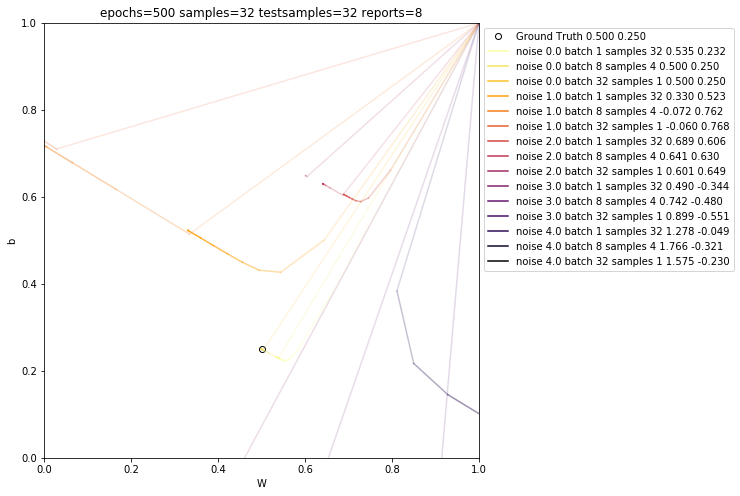

In [16]:
pathplots(500, 32, 32, 8,
    'epochs={} samples={} testsamples={} reports={}'.format(500, 32, 32, 8),
    noises=[0.0, 1.0, 2.0, 3.0, 4.0], bits=[0, 3, 5])

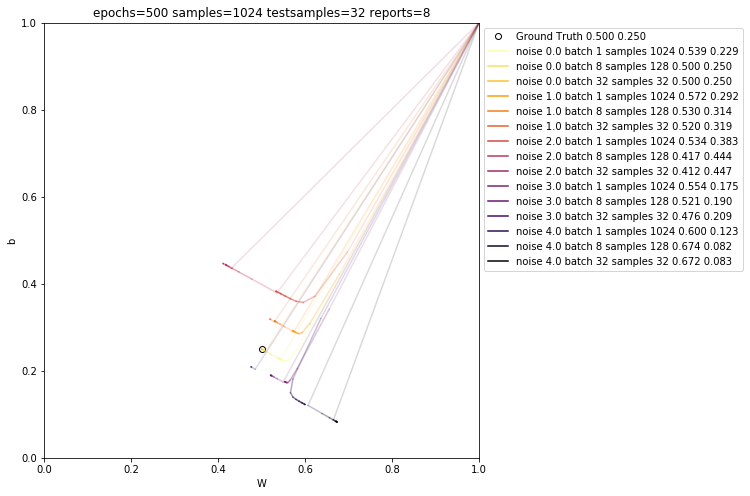

In [17]:
pathplots(500, 1024, 32, 8,
    'epochs={} samples={} testsamples={} reports={}'.format(500, 1024, 32, 8),
    noises=[0.0, 1.0, 2.0, 3.0, 4.0], bits=[0, 3, 5])

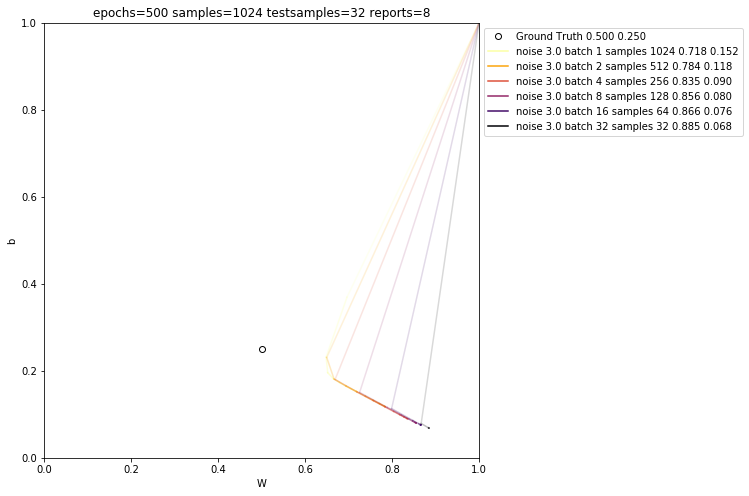

In [18]:
pathplots(500, 1024, 32, 8,
    'epochs={} samples={} testsamples={} reports={}'.format(500, 1024, 32, 8),
    noises=[3.0], bits=[0, 1, 2, 3, 4, 5])

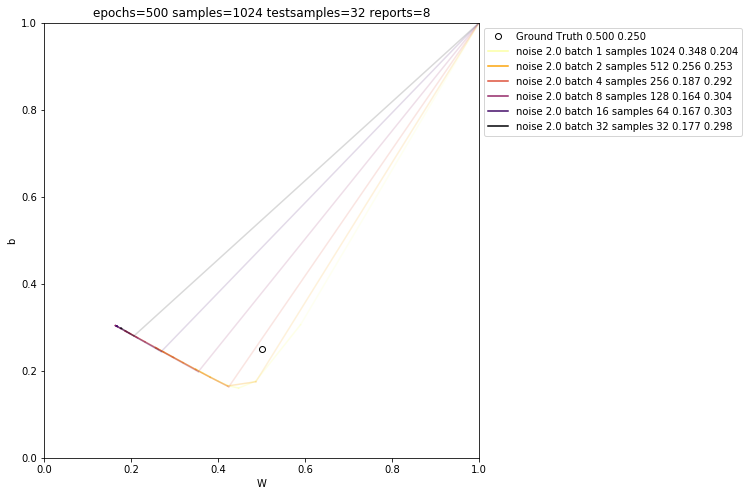

In [19]:
pathplots(500, 1024, 32, 8,
    'epochs={} samples={} testsamples={} reports={}'.format(500, 1024, 32, 8),
    noises=[2.0], bits=[0, 1, 2, 3, 4, 5])

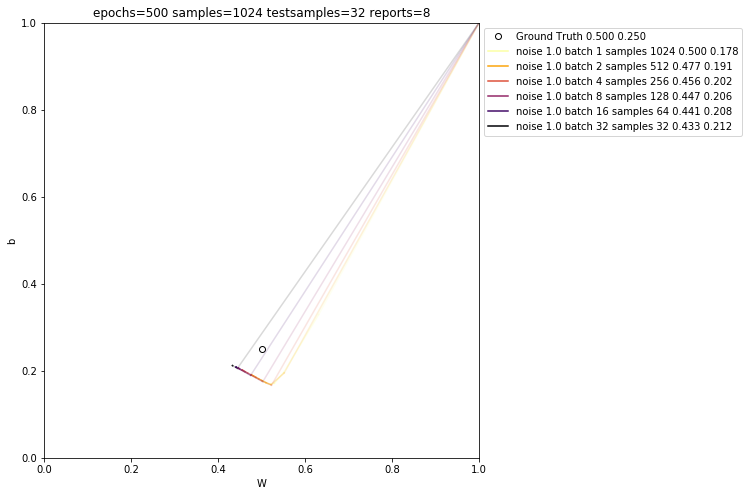

In [20]:
pathplots(500, 1024, 32, 8,
    'epochs={} samples={} testsamples={} reports={}'.format(500, 1024, 32, 8),
    noises=[1.0], bits=[0, 1, 2, 3, 4, 5])

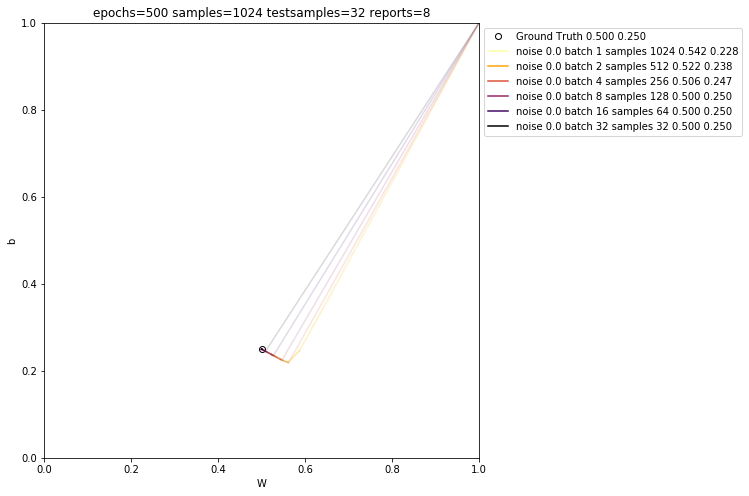

In [21]:
pathplots(500, 1024, 32, 8,
    'epochs={} samples={} testsamples={} reports={}'.format(500, 1024, 32, 8),
    noises=[0.0], bits=[0, 1, 2, 3, 4, 5])

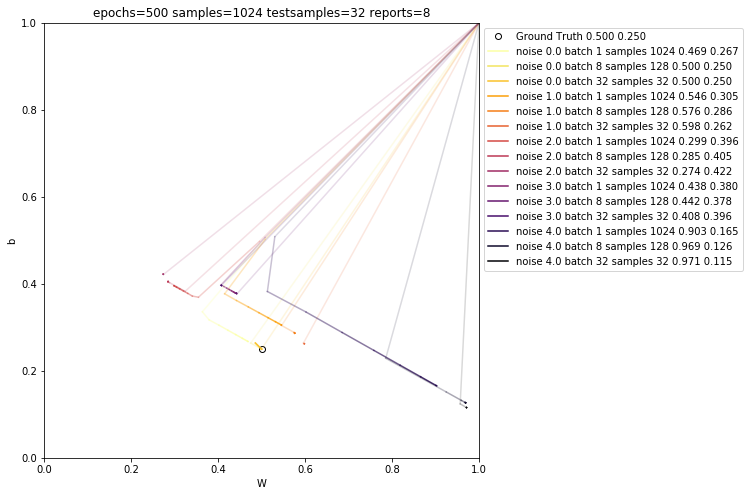

In [22]:
pathplots(500, 1024, 32, 8,
    'epochs={} samples={} testsamples={} reports={}'.format(500, 1024, 32, 8),
    noises=[0.0, 1.0, 2.0, 3.0, 4.0], bits=[0, 3, 5], step=adam)